In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from functools import partial
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from pathlib import Path
import PIL
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19
from typing import List, Tuple

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 32

# Data

## Target ds

animecharacterfaces, by Kaggle user *aadilmalik94*

In [3]:
#anime_faces_path = Path('/kaggle/input/anime-faces-safebooru/anime-faces').resolve()
anime_faces_path = Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data').resolve()

## Input ds

In [4]:
celeba_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')
#input_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
input_fns = celeba_path.ls()
input_fns

(#202599) [Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/083648.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/168202.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/125778.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/059339.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/032501.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/160139.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/046754.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/178961.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/123482.jpg'),Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/039337.jpg')...]

The ds path passed to `dblock.dataloaders()` or `ImageDataLoaders.from_dblock()` will be forwarded
to `get_items`, which will return a list of items, usually a list of image paths if `get_items=get_image_files`.

So, for each item, we are expected to receive a filename `fn` and be able to
derive x and y from it, with `get_x(fn)` and `get_y(fn)`.

For unpaired image to image translation, we can:
* Use the target images ds path as the DataBlock `source`. Then, `get_y` can just return the path received.
* Load independently the filenames of the input images ds; let's call it `input_fns`. Then, `get_x` would need to return a random item from `input_fns`. `get_x` is called every time a data item is used; so, by using random, we can be sure every x is not tied to a fixed y; i.e., they won't be together in the same (x, y) batch every epoch for loss calculation.


---

In [5]:
def get_random_input(fn):
    return input_fns[random.randint(0, len(input_fns)-1)]
    
dblock = DataBlock(blocks = (ImageBlock, ImageBlock),
                   get_x = get_random_input,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
main_path = anime_faces_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

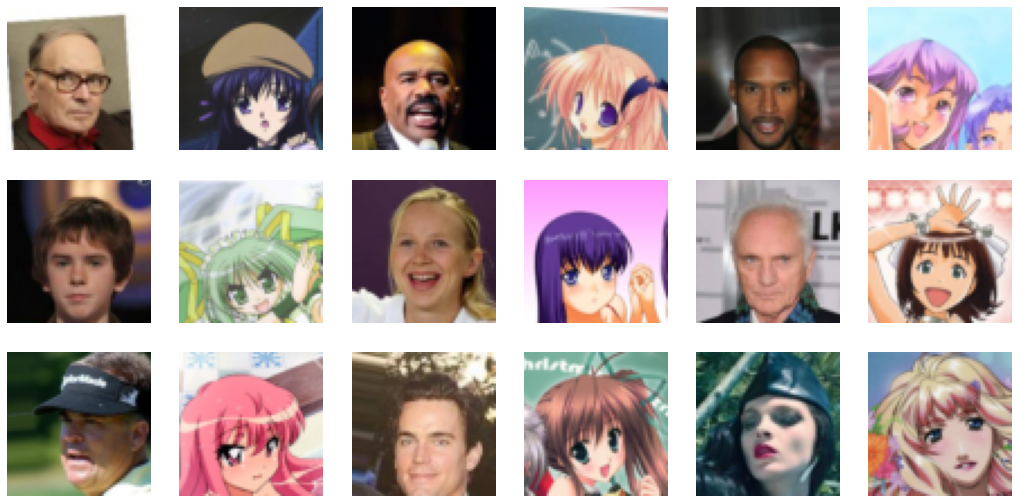

In [6]:
dls.show_batch()

# Loss function

## Content loss

In [7]:
class FeaturesCalculator:
    def __init__(self, vgg_style_layers_idx:List[int], vgg_content_layers_idx:List[int],
                 vgg:nn.Module=None, normalize_inputs=False, device:torch.device=None):
        self.vgg = vgg19(pretrained=True) if vgg is None else vgg
        self.vgg.eval()
        if device is not None: self.vgg.to(device)
        modules_to_hook = [self.vgg.features[idx] for idx in (*vgg_style_layers_idx, *vgg_content_layers_idx)]
        self.hooks = hook_outputs(modules_to_hook, detach=False)
        self.style_ftrs_hooks = self.hooks[:len(vgg_style_layers_idx)]
        self.content_ftrs_hooks = self.hooks[len(vgg_style_layers_idx):]
        self.normalize_inputs = normalize_inputs
        # TODO: when to remove hooks??? `clean` method????
    
    def _get_hooks_out(self, hooks):
        return [h.stored for h in hooks]
    
    def _forward(img_t:torch.Tensor):
        if self.normalize_inputs: 
            mean, std = fastai.vision.imagenet_stats
            img_t = fastai.vision.normalize(img_t, torch.tensor(mean), torch.tensor(std))
        self.vgg(img_t)
    
    def calc_style(self, img_t:torch.Tensor) -> List[torch.Tensor]:
        self.vgg(img_t)
        return self._get_hooks_out(self.style_ftrs_hooks)
    
    def calc_content(self, img_t:torch.Tensor) -> List[torch.Tensor]:
        self.vgg(img_t)
        return self._get_hooks_out(self.content_ftrs_hooks)
    
    def calc_style_and_content(self, img_t:torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        self.vgg(img_t)
        style_ftrs = self._get_hooks_out(self.style_ftrs_hooks)
        content_ftrs = self._get_hooks_out(self.content_ftrs_hooks)
        return style_ftrs, content_ftrs

In [8]:
vgg_content_layers_idx = [22]
ftrs_calc = FeaturesCalculator([], vgg_content_layers_idx, device=device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In the next cell, there are two versions of content loss, with the same behaviour but different implementation:
* A functional version, returned by `get_content_loss`. A callback parameter is needed 
* A callback version. Although less intuitive, this may be preferable because it stores the loss value inside `learner.loss_func.content_loss`, making it accessible to the metrics display system. If you want the learner to display the content loss every epoch, it only requires passing `metrics=['content_loss', ...]` to GANLearner.__init__.

In [97]:
content_loss_func = nn.MSELoss(reduction='mean')


def get_content_loss(last_input_cb):
    def _content_loss(output, target):
        input_content_ftrs = ftrs_calc.calc_content(last_input_cb.x)[0]
        output_content_ftrs = ftrs_calc.calc_content(output)[0]
        return content_loss_func(output_content_ftrs, input_content_ftrs)
    
    return _content_loss


class ContentLossCallback(Callback):
    def __init__(self, weight=1., ftrs_calc=None, device=None):
        self.weight = weight
        if ftrs_calc is None:
            vgg_content_layers_idx = [22]
            ftrs_calc = FeaturesCalculator([], vgg_content_layers_idx, device=device)
        self.ftrs_calc = ftrs_calc
        
    def after_loss(self):
        if self.gan_trainer.gen_mode:
            input_content_ftrs = self.ftrs_calc.calc_content(self.x)[0]
            output_content_ftrs = self.ftrs_calc.calc_content(self.pred)[0]
            loss_val = self.weight * content_loss_func(output_content_ftrs, input_content_ftrs)
            # Store result inside learn.loss_func to make it visible to metrics display
            self.learn.loss_func.content_loss = loss_val            
            # This will probably stop working once a new fastai version is released, as backward 
            # won't be called on learn.loss anymore, but on learn.loss_grad
            self.learn.loss += loss_val

The following functions are only useful if you decide to use the functional version of content loss and want to combine it with Wasserstein loss:

In [10]:
def gen_wgan_loss(fake_pred, output, target): return fake_pred.mean()
def crit_wgan_loss(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean()


def get_gen_wgan_content_loss(last_input_cb, content_loss_w=1.):
    content_loss = get_content_loss(last_input_cb)
    
    def _gen_wgan_content_loss(fake_pred, output, target):
        wgan_loss = gen_wgan_loss(fake_pred, output, target) 
        cont_loss = content_loss(output, target)
        return wgan_loss + content_loss_w * cont_loss
    
    return _gen_wgan_content_loss


def create_wgan_w_content_loss_learner(dls, generator, critic, cbs=None, **kwargs):
    if cbs is None: cbs = []
    last_input_cb=Callback()
    cbs.append(last_input_cb)
    gen_loss = get_gen_wgan_content_loss(last_input_cb)
    return GANLearner(dls, generator, critic, gen_loss, crit_wgan_loss,
                      cbs=cbs, **kwargs)

## Gradient penalty

In [11]:
class GANGPCallback(Callback):
    def __init__(self, plambda=10., epsilon_sampler=None): 
        self.plambda = plambda
        if epsilon_sampler is None: epsilon_sampler = random_epsilon_gp_sampler
        self.epsilon_sampler = epsilon_sampler
        
    def _gradient_penalty(self, real, fake, plambda, epsilon_sampler):
        epsilon = epsilon_sampler(real, fake)
        x_hat = epsilon * real + (1 - epsilon) * fake
        x_hat_pred = self.model.critic(x_hat).mean()

        grads = torch.autograd.grad(outputs=x_hat_pred, inputs=x_hat, create_graph=True)[0]
        return plambda * ((grads.norm() - 1)**2)    
        
    def after_loss(self):
        if not self.gan_trainer.gen_mode:
            # In critic mode, GANTrainer swaps x and y; so, here x is original y (real target)
            real = self.x
            assert not self.y.requires_grad
            fake = self.model.generator(self.y).requires_grad_(True)
            # This will probably stop working once a new fastai version is released, as backward 
            # won't be called on learn.loss anymore, but on learn.loss_grad
            self.learn.loss += self._gradient_penalty(real, fake, self.plambda, self.epsilon_sampler)


def random_epsilon_gp_sampler(real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
    # A different random value of epsilon for any element of a batch
    epsilon_vec = torch.rand(real.shape[0], 1, 1, 1, dtype=torch.float, device=real.device, requires_grad=False)
    return epsilon_vec.expand_as(real)


# Architecture tweaks

In [13]:
def drop_bns(m):
    idxs_to_drop = []
    for i, child in enumerate(m.children()):
        if isinstance(child, nn.BatchNorm2d):
            idxs_to_drop.append(i)
        else:
            drop_bns(child)
    for idx in idxs_to_drop: m[idx] = nn.Identity()
        
def replace_encoder_bn(m):
    idxs_to_replace = []
    for i, child in enumerate(m.children()):
        if isinstance(child, UnetBlock): break
        if isinstance(child, nn.BatchNorm2d):
            idxs_to_replace.append(i)
        else:
            replace_encoder_bn(child)
    for idx in idxs_to_replace: 
        m[idx] = InstanceNorm(m[idx].num_features, affine=True)
        
def replace_decoder_bn(unet):
    for l in unet.layers:
        if isinstance(l, UnetBlock):
            l.bn = InstanceNorm(l.bn.num_features, affine=True)    
        
def replace_unet_bn(unet):
    replace_encoder_bn(unet)
    replace_decoder_bn(unet)
        
def drop_decoder_bn(unet):
    for l in unet.layers:
        if isinstance(l, UnetBlock):
            l.bn = nn.Identity()

------------------

# Training

In [14]:
def custom_save_model(learner, filename, base_path='/kaggle/working'):
    if isinstance(base_path, str): base_path = Path(base_path)
    if not isinstance(base_path, Path): raise Exception('Invalid base_path')
    file = join_path_file(filename, base_path/learner.model_dir, ext='.pth')
    save_model(file, learner.model, learner.opt)
    
def custom_load_model(learner, filename, with_opt=True, device=None, 
                      base_path='/kaggle/input/new-face2anime-weights', **kwargs):
    if isinstance(base_path, str): base_path = Path(base_path)
    if not isinstance(base_path, Path): raise Exception('Invalid base_path')
    if device is None and hasattr(learner.dls, 'device'): device = learner.dls.device
    if learner.opt is None: learner.create_opt()
    #file = join_path_file(filename, base_path/learner.model_dir, ext='.pth')
    file = base_path/f'{filename}.pth'
    load_model(file, learner.model, learner.opt, with_opt=with_opt, device=device, **kwargs)
    
def predict_n(learner, n_imgs, max_bs=64):
    dummy_path = Path('')
    dl = learner.dls.test_dl([dummy_path]*n_imgs, bs=max_bs)   
    inp, imgs_t, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch((inp,) + tuplify(dec_imgs_t), max_n=n_imgs)
    return dec_batch
    
def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 2, figsize=(6, n_imgs * 3))
    for i, (inp, pred_img) in enumerate(preds_batch):
        inp.show(ax=axs[i][0])
        pred_img.show(ax=axs[i][1])

## TR 1: Simple WGAN

In [ ]:
generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                 loss_func=lambda *args: 0, #cbs=[last_input_cb],
                                )
generator = generator_learner.model
critic = xresnet18(n_out=1)
learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                        cbs=[])
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False
learn.fit(1, 2e-4, wd=0.)

In [ ]:
learn.fit(4, 2e-4, wd=0.)

In [ ]:
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(5, 2e-4, wd=0.)

In [ ]:
learn.show_results(ds_idx=0)

## TR 2: WGAN-GP, SN (and no BN, not exactly) in critic

### Tr 2a: still some BN in critic (in the first layers and in shortcut of res blocks)

In [ ]:
generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                 loss_func=lambda *args: 0,
                                )
generator = generator_learner.model
# I think it's wrong. There's a lot of BN everywhere
critic = xresnet18(n_out=1, norm_type=NormType.Spectral)
learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                        clip=None, cbs=[GANGPCallback(plambda=10.)])
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False
learn.fit(1, 2e-4, wd=0.)

In [ ]:
custom_save_model(learn, 'f2a_tr2a_1ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(3, 2e-4)
custom_save_model(learn, 'f2a_tr2a_4ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(6, 2e-4)
custom_save_model(learn, 'f2a_tr2a_10ep')
learn.show_results(ds_idx=0)

Gradients end up exploding.

### TR 2b: WGAN-GP, SN (and no BN at all) in critic

In [103]:
def create_learner_2b(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0,
                                    )
    generator = generator_learner.model
    
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral)
    drop_bns(critic)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_2b()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr2b_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr2b_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr2b_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

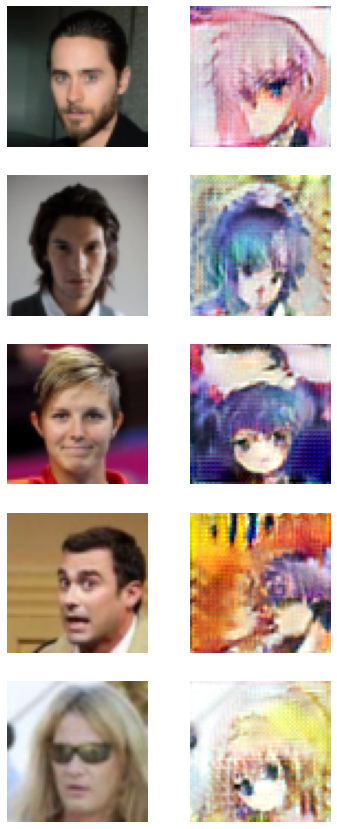

In [148]:
learn = create_learner_2b(for_inference=True)
custom_load_model(learn, 'f2a_tr2b_50ep', with_opt=False)
predict_show_n(learn, 5)

## TR 3: WGAN-GP, SN (and no BN) and LeakyReLU in critic [TR 2 w/ LeakyReLU in critic]

In [104]:
def create_learner_3(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0,
                                    )
    generator = generator_learner.model
    
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)
    
    cbs = []
    if not for_inference:
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_3()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr3_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr3_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr3_50ep')
learn.show_results(ds_idx=0)

Using LeakyReLU, quality seems worse at the beginning, but it ends up being even better.

---

Show results after returning to work:

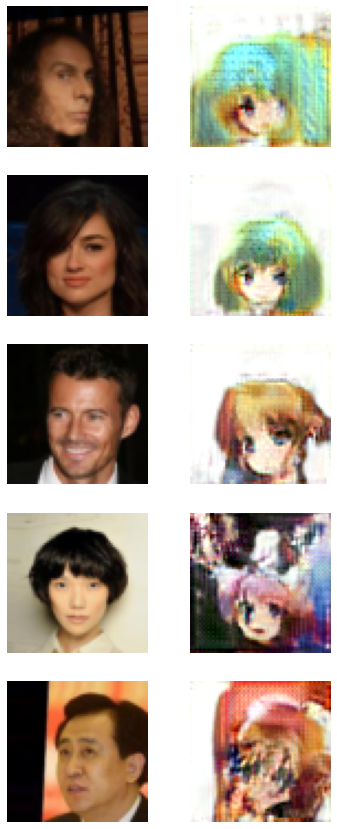

In [149]:
learn = create_learner_3(for_inference=True)
custom_load_model(learn, 'f2a_tr3_50ep', with_opt=False)
predict_show_n(learn, 5)

## TR 4: Hinge-GP, SN (and no BN) and LeakyReLU in critic [TR 3 w/ hinge loss]

## TR 5: WGAN-GP, SN (and no BN) and LeakyReLU in critic [TR 3 w/ content loss also]

### 5a: content loss weight = 1

In [105]:
def create_learner_5a(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0)
    generator = generator_learner.model
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    # learn = create_wgan_w_content_loss_learner(dls, generator, critic, clip=None, 
    #                                            opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
    #                                            cbs=[GANGPCallback(plambda=10.)])
    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_5a()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr5a_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr5a_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr5a_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

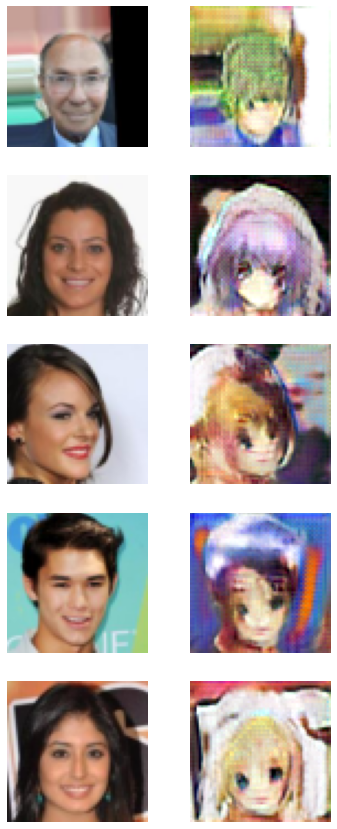

In [150]:
learn = create_learner_5a(for_inference=True)
custom_load_model(learn, 'f2a_tr5a_50ep', with_opt=False)
predict_show_n(learn, 5)

### 5b: content loss weight = 0.1

In [106]:
def create_learner_5b(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0)
    generator = generator_learner.model
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_5b()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr5b_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr5b_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr5b_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

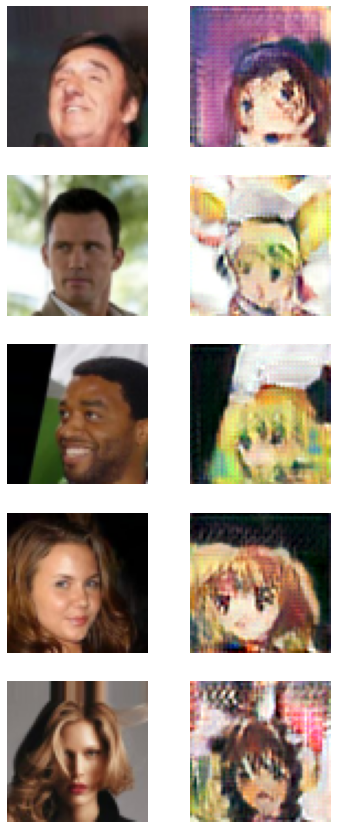

In [151]:
learn = create_learner_5b(for_inference=True)
custom_load_model(learn, 'f2a_tr5b_50ep', with_opt=False)
predict_show_n(learn, 5)

## TR 6: WGAN-GP + content loss, SN (and no BN) and LeakyReLU in critic, instance norm in generator encoder

### 6b: content loss weight = 0.1

In [107]:
def create_learner_6b(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0)#, norm_type=NormType.Instance)
    generator = generator_learner.model
    replace_encoder_bn(generator)
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_6b()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr6b_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr6b_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'f2a_tr6b_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

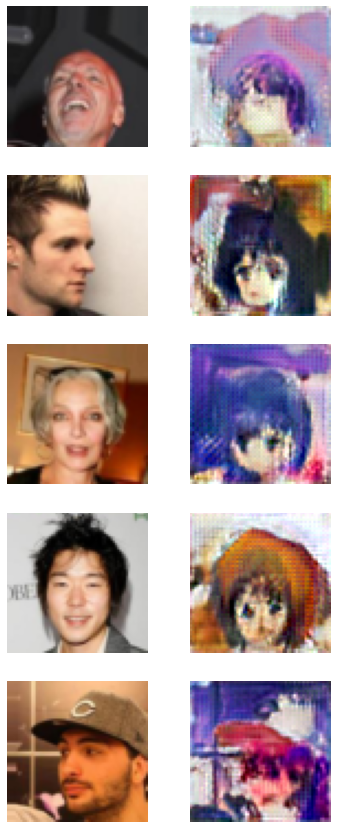

In [152]:
learn = create_learner_6b(for_inference=True)
custom_load_model(learn, 'f2a_tr6b_50ep', with_opt=False)
predict_show_n(learn, 5)

## TR 7: WGAN-GP + content loss, SN (and no BN) and LeakyReLU in critic, instance norm in full generator (encoder and decoder)

### 7b: content loss weight = 0.1

#### 7b1: only 1 IN per Unet block

In [108]:
def create_learner_7b1(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0)
    generator = generator_learner.model
    replace_unet_bn(generator)
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_7b1()
learn.fit(10, 2e-4)
custom_save_model(learn, 'f2a_tr7b1_10ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'f2a_tr7b1_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr7b1_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

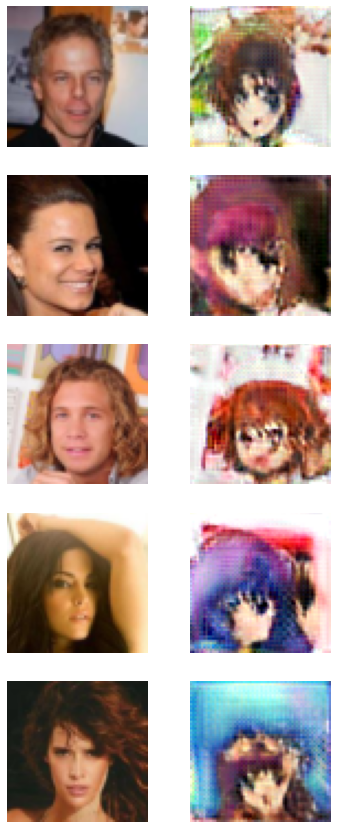

In [153]:
learn = create_learner_7b1(for_inference=True)
custom_load_model(learn, 'f2a_tr7b1_50ep', with_opt=False)
predict_show_n(learn, 5)

#### 7b2: IN after every conv inside Unet blocks

In [109]:
def create_learner_7b2(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0, norm_type=NormType.Instance)
    generator = generator_learner.model
    replace_unet_bn(generator)
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_7b2()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr7b2_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr7b2_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr7b2_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

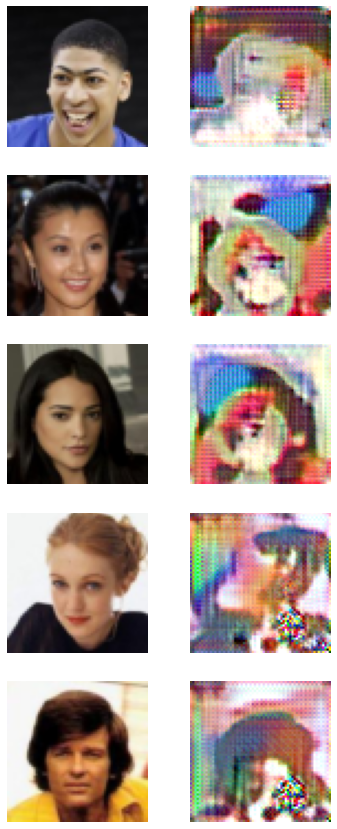

In [155]:
learn = create_learner_7b2(for_inference=True)
custom_load_model(learn, 'f2a_tr7b2_50ep', with_opt=False)
predict_show_n(learn, 5)

#### 7b3: [like 7b2 w/ another iter ratio] IN after every conv inside Unet blocks, n_iters ratio=1

In [110]:
def create_learner_7b3(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0, norm_type=NormType.Instance)
    generator = generator_learner.model
    replace_unet_bn(generator)
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'),
                            switcher=FixedGANSwitcher(n_crit=1, n_gen=1))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_7b3()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr7b3_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr7b3_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr7b3_50ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

In [ ]:
learn = create_learner_7b3(for_inference=True)
custom_load_model(learn, 'f2a_tr7b3_50ep', with_opt=False)
predict_show_n(learn, 5)

## TR 8: WGAN-GP + content loss, SN (and no BN) and LeakyReLU in critic, instance norm in generator encoder, no norm in decoder

### 8a: content loss weight = 1

In [111]:
def create_learner_8a(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0, norm_type=None)
    generator = generator_learner.model
    replace_encoder_bn(generator)
    drop_decoder_bn(generator)
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=1., ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs, metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_8a()
learn.fit(10, 2e-4)
custom_save_model(learn, 'f2a_tr8a_10ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(10, 2e-4)
custom_save_model(learn, 'f2a_tr8a_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr8a_50ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(20, 2e-4)
custom_save_model(learn, 'f2a_tr8a_70ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr8a_100ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(50, 2e-4)
custom_save_model(learn, 'f2a_tr8a_150ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(50, 2e-4)
custom_save_model(learn, 'f2a_tr8a_200ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

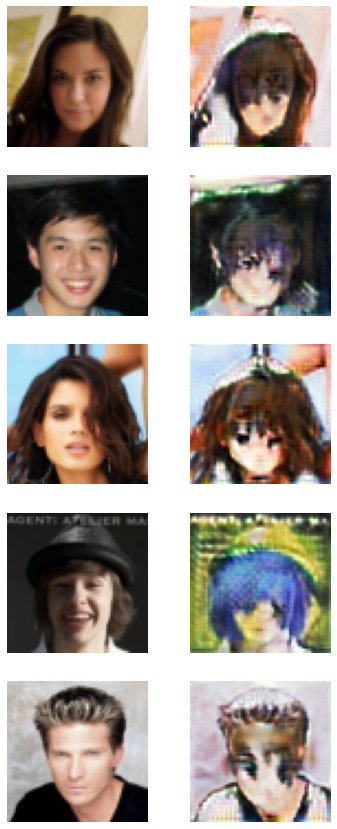

In [156]:
learn = create_learner_8a(for_inference=True)
custom_load_model(learn, 'f2a_tr8a_50ep', with_opt=False)
predict_show_n(learn, 5)

### 8b: content loss weight = 0.1

In [112]:
def create_learner_8b(for_inference=False):
    generator_learner = unet_learner(dls, xresnet18, normalize=True, n_out=n_channels, pretrained=False, 
                                     loss_func=lambda *args: 0, norm_type=None)
    generator = generator_learner.model
    replace_encoder_bn(generator)
    drop_decoder_bn(generator)
    
    critic = xresnet18(n_out=1, norm_type=NormType.Spectral, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
    drop_bns(critic)

    cbs = []
    if not for_inference:
        cbs.append(ContentLossCallback(weight=0.1, ftrs_calc=ftrs_calc, device=device))
        cbs.append(GANGPCallback(plambda=10.))
    learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                            clip=None, cbs=cbs,
                            metrics=LossMetric('content_loss'))
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    return learn

In [ ]:
learn = create_learner_8b()
learn.fit(5, 2e-4)
custom_save_model(learn, 'f2a_tr8b_5ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(15, 2e-4)
custom_save_model(learn, 'f2a_tr8b_20ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(30, 2e-4)
custom_save_model(learn, 'f2a_tr8b_50ep')
learn.show_results(ds_idx=0)

In [ ]:
learn.fit(50, 2e-4)
custom_save_model(learn, 'f2a_tr8b_100ep')
learn.show_results(ds_idx=0)

---

Show results after returning to work:

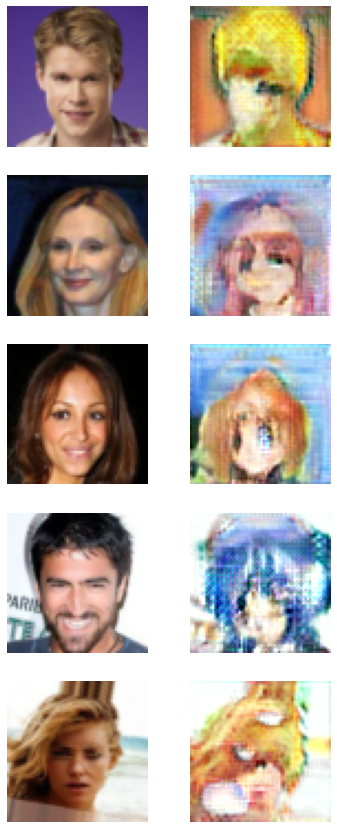

In [157]:
learn = create_learner_8b(for_inference=True)
custom_load_model(learn, 'f2a_tr8b_50ep', with_opt=False)
predict_show_n(learn, 5)

# Evaluation

In [130]:
import shutil
base_fid_samples_path = Path('/kaggle/working/fid_samples')
n_fid_imgs = 10000

def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'real').mkdir()
        
def save_real_imgs(dls, n_imgs=10000, use_input_ds=False):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            tuple_idx = 0 if use_input_ds else 1
            img_t = dec_b[i][tuple_idx]
            img = PILImage.create(img_t)
            img_idx = n_imgs_left-1
            img.save(base_fid_samples_path/f'real/{img_idx}.jpg')
            #if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1

def save_fake_imgs(learner, n_imgs=10000, **predict_n_kwargs):
    base_path = base_fid_samples_path
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    for i, (inp, img) in enumerate(preds_batch):
        PILImage.create(img).save(base_path/f'fake/{i}.jpg')

In [ ]:
!rm -R $base_fid_samples_path

In [ ]:
# download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [142]:
def eval_models(builders, n_ep):
    for builder in builders:
        model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'f2a_tr{model_id}_{n_ep}ep', with_opt=False)
        save_fake_imgs(learner, n_imgs=n_fid_imgs)
        print(f'---- {model_id} ----')
        !python -m pytorch_fid {base_fid_samples_path/'fake'} {base_fid_samples_path/'real'}

## Results after 50 epochs

In [139]:
builders = [create_learner_2b, create_learner_3, create_learner_5a, 
            create_learner_5b, create_learner_6b, create_learner_7b1, 
            create_learner_7b2, create_learner_8a, create_learner_8b]

In [ ]:
# Fake vs real target
save_real_imgs(dls, n_fid_imgs)
eval_models(builders, '50')

In [ ]:
# Fake vs real input
save_real_imgs(dls, n_fid_imgs, use_input_ds=True)
eval_models(builders, '50')

| Model ID | FID fake vs real target | FID fake vs real input | Avg |
| : | : | : | : |
| 2b | 102.2 | 253.6 | 177.9 |
| 3 | 111.3 | 250.7 | 181 |
| 5a |  98.0 | 222.6 | 160.3 |
| 5b | 108.9 | 258.6 | 183.8 |
| 6b | 123.5 | 261.2 | 192.4 |
| 7b1 | 118.9 | 253.4 | 186.2 |
| 7b2 | 158.8 | 263.5 | 211.2 |
| 8a | **92.3** | **206.0** | **149.15** |
| 8b |  110.4 | 241.2 | 175.8 |




## Results after 100 epochs

|Model ID | FID fake vs real target | FID fake vs real input | Avg |
| : | : | : | : |
| 8a | 78.8 | 218.8 | 148.8 |

## Results after 150 epochs

| Model ID | FID fake vs real target | FID fake vs real input | Avg |
| : | : | : | : |
| 8a | 70.0 | 206.6 | 138.3 |

## Results after 200 epochs

| Model ID | FID fake vs real target | FID fake vs real input | Avg |
| : | : | : | : |
| 8a | 73.8 | 214.8 | 144.3 |

# TODO

* Try Hinge loss (tr4)
* Don't forget get_image_files can be make training slower at the beginning
* Maybe, add cycle consistency loss (this would slow down training), another generator, ... (cycle-GAN)
* Try bs = 1
* Clean callbacks attrs (is it needed???)
* If no results are gotten:
  * use bigger dataset
  * use more specific anime faces dataset (it could be worse for production)
  * think about initializations
  * add/vary transforms
* Minor tweaks once it works:
  * Train with TTUR
  * Add dropout